In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Reshape, Input, Dense
from tensorflow.keras.models import Model




2024-06-19 22:01:40.231259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 22:01:40.231377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 22:01:40.372746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

!tar -xvf VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_11-May-2012.tar


!git clone https://github.com/tensorflow/models.git
!cd models/research

!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!pip install .

!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/dataset_tools/create_pascal_tf_record.py

!python create_pascal_tf_record.py --data_dir=VOCdevkit --year=VOC2007 --output_path=pascal_train.record
!python create_pascal_tf_record.py --data_dir=VOCdevkit --year=VOC2007 --output_path=pascal_val.record --set=val


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-19 22:01:53--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: 'VOCtrainval_06-Nov-2007.tar'

VOCtrainval_06-Nov- 100%[===================>] 438.72M  28.8MB/s    in 25s     

2024-06-19 22:02:19 (17.3 MB/s) - 'VOCtrainval_06-Nov-2007.tar' saved [460032000/460032000]

--2024-06-19 22:02:20--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: 'VOCtrainval_11-May-2012.tar'

VOCtrainval_11-May- 100%[==========

In [11]:

def load_dataset(record_file, batch_size=32):
    raw_dataset = tf.data.TFRecordDataset(record_file)

    def parse_example(example_proto):
        features = {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
            'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        }
        parsed_features = tf.io.parse_single_example(example_proto, features)
        image = tf.io.decode_jpeg(parsed_features['image/encoded'], channels=3)
        image = tf.image.resize(image, (224, 224))
        xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'])
        xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'])
        ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'])
        ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'])
        labels = tf.sparse.to_dense(parsed_features['image/object/class/label'])
        bboxes = tf.stack([xmin, ymin, xmax, ymax], axis=-1)
        return image, {'bbox_output': bboxes, 'class_output': labels}

    dataset = raw_dataset.map(parse_example)
    dataset = dataset.batch(batch_size)
    return dataset

train_record_path = '/kaggle/working/pascal_train.record'
val_record_path = '/kaggle/working/pascal_val.record'

train_dataset = load_dataset(train_record_path)
val_dataset = load_dataset(val_record_path)





In [27]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.models import Model

def create_model(input_shape, num_classes):
    base_model = MobileNetV2(include_top=False, input_shape=input_shape)
    base_model.trainable = False  
    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    bbox_output = Conv2D(4, (1, 1), activation='linear', name='bbox_output')(x)
    bbox_output = Reshape((4,7*7))(bbox_output)
    bbox_output = Dense(7,activation = 'linear')(bbox_output)
    bbox_output = Reshape((-1, 4),name='r2')(bbox_output)
    class_output = Conv2D(num_classes, (1, 1), activation='linear', name='class_output')(x)
    class_output = Reshape((num_classes,7*7))(class_output)
    class_output = Dense(7,activation = 'softmax')(class_output)
    class_output = Reshape((-1, num_classes), name= 'r1')(class_output)
    model = Model(inputs=base_model.input, outputs=[bbox_output, class_output])

    return model

input_shape = (224, 224, 3)
num_classes = 20  
model = create_model(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam()

def custom_loss(y_true, y_pred):
    
    bbox_loss = tf.keras.losses.mse(y_true[0], y_pred[0])
    class_loss = tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])
    return (bbox_loss + class_loss)/2

model.compile(optimizer=optimizer, loss=custom_loss)
batch_size = 64
train_dataset = tf.data.Dataset.range(8000).map(lambda x: (tf.random.normal((224, 224, 3)), (tf.random.normal((7, 4)), tf.one_hot(tf.random.uniform((7,), maxval=num_classes, dtype=tf.int32), depth=num_classes)))).batch(batch_size)
val_dataset = tf.data.Dataset.range(1000).map(lambda x: (tf.random.normal((224, 224, 3)), (tf.random.normal((7, 4)), tf.one_hot(tf.random.uniform((7,), maxval=num_classes, dtype=tf.int32), depth=num_classes)))).batch(batch_size)


epochs = 25

tf.keras.utils.plot_model(
    model,
    to_file='/kaggle/working/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',  
    expand_nested=False,
    dpi=300  
)



In [28]:
with tf.device('/device:gpu:0'):
    
    his = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 299ms/step - loss: 5.3251 - val_loss: 2.9751
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 250ms/step - loss: 2.1503 - val_loss: 2.7432
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - loss: 2.5276 - val_loss: 1.8606
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - loss: 2.4749 - val_loss: 4.0494
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - loss: 2.1618 - val_loss: 2.4845
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - loss: 1.8669 - val_loss: 1.6784
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - loss: 1.9002 - val_loss: 2.7055
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - loss: 2.0903 - val_loss: 2.3459
Epoch 9/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - loss: 1.3125 - val_loss: 1.4378
Epoch 10/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - loss: 1.8766 - val_loss: 2.2119
Epoch 11/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - loss: 2.2594 - val_loss: 3.5243
Epoch 12/25
125/125

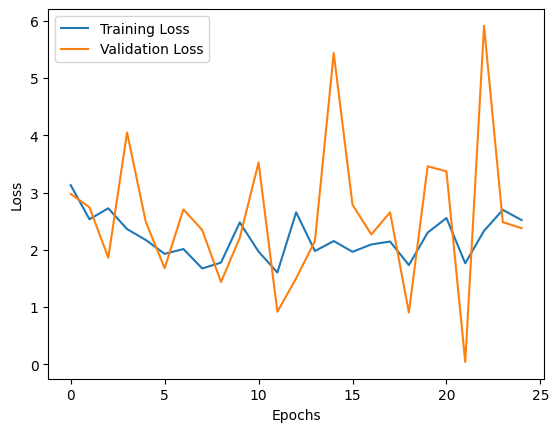

In [29]:
import matplotlib.pyplot as plt
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()